In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


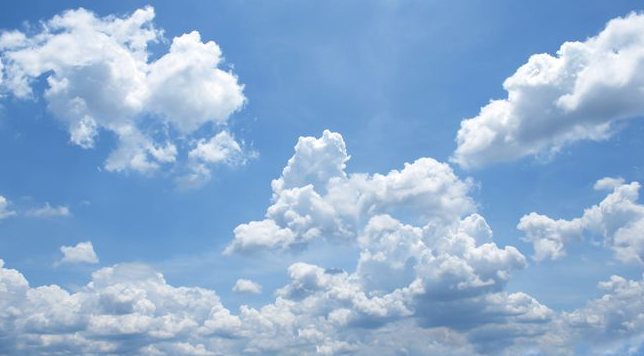

In [18]:
from keras.models import Model
from IPython.display import display
from IPython.display import Image as _Imgdis
from keras.preprocessing.image import array_to_img, img_to_array, load_img
image_path = '/content/gdrive/MyDrive/pytest_img/opencv/cloud.png'
display(_Imgdis(filename=image_path))

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalizati

In [20]:
model = InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [21]:
layer_settings = {
  "mixed4": 1.0,
  "mixed5": 1.5,
  "mixed6": 2.0,
  "mixed7": 2.5,
}

In [22]:
outputs_dict = dict([(layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]])
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [23]:
feature_extractor.output

{'mixed4': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed4')>,
 'mixed5': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>,
 'mixed6': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed6')>,
 'mixed7': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed7')>}

In [24]:
import tensorflow as tf
def compute_loss(input_image):
  features = feature_extractor(input_image) # 모델 레이어의 출력 결과를 추출
  loss = tf.zeros(shape=()) # 손실을 0으로 초기화
  for name in features.keys(): # 출력 레이어 각각에 대하여 (mixed4~mixed7)
    coeff = layer_settings[name] # 적용할 가중치를 설정한 값에서 가져온다 (1.0~2.5)
    activation = features[name] # 현재 레이어가 이미지를 인식한 결과
    loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :])) # 위 박스 참조. (배치차원, 높이, 너비, 색상)
  return loss


In [25]:
def gradient_ascent_step(image, learning_rate):
  with tf.GradientTape() as tape: # 그래디언트 값(grads)을 직접 다루기 위해 tf.GradientTape()을 사용
    tape.watch(image) # 어떤 값을 추적할지를 .watch()로 명시
    loss = compute_loss(image) # 앞에서 작성한 손실함수로 이미지에 대한 손실값을 계산
  grads = tape.gradient(loss, image) # 손실함수에 대한 이미지의 그래디언트를 계산
  grads = tf.math.l2_normalize(grads) # 안정적인 학습을 위해 그래디언트 크기를 일정 수준으로 유지하는 L2 정규화를 한다
  image += learning_rate * grads # 이미지를 그래디언트가 가리키는 방향으로 업데이트
  return loss, image

In [26]:
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
  for i in range(iterations):
    loss, image = gradient_ascent_step(image, learning_rate) # 이미지 업데이트 과정 반복
    if max_loss is not None and loss > max_loss: # 과도한 변형을 막기 위해 임계값 설정
      break
    print(f"...스텝 {i}에서 손실값: {loss:.2f}")

  return image

In [27]:
def preprocess_image(image_path):
  img = load_img(image_path) # 이미지를 불러온다
  img = img_to_array(img) # 넘파이 배열로 변환
  img = np.expand_dims(img, axis=0) # 딥러닝 모델 구조에 맞게 맨 앞에 배치 차원을 추가한다
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img

In [28]:
def deprocess_image(img):
  img = img.reshape((img.shape[1], img.shape[2], 3)) # 이미지를 (높이, 너비, 3)의 구조로 만든다
  img += 1.0
  img *= 127.5
  img = np.clip(img, 0, 255).astype("uint8") # 값을 0~255 사이의 값으로 제한한다
  return img

In [29]:
import numpy as np
original_img = preprocess_image(image_path) # 전처리 수행
original_shape = original_img.shape[1:3]
original_shape

(356, 644)

In [30]:
step = 20 # 학습률
num_octave = 3 # 이미지를 3가지 옥타브(이미지의 스케일)로 처리
octave_scale = 1.4 # 각 옥타브에서 수행할 이미지 크기 조정 비율
iterations = 30 # 각 옥타브에서 수행할 최대 반복 횟수
max_loss = 15.0 # 허용하는 최대 손실값(임계값)

In [31]:
successive_shapes = [original_shape] # 원본 이미지의 높이와 너비 정보
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1] # 순서 반전

In [32]:
# 원본 이미지를 가장 작은 옥타브 크기인 successive_shapes[0]으로 조정한다
# 이 이미지는 디테일을 복원하는 데 사용된다
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

# 원본 이미지의 복사본을 만든다
# 복사본은 각 옥타브에서 수정된다
img = tf.identity(original_img)

In [33]:
for i, shape in enumerate(successive_shapes):
  print(f"{shape} 크기의 {i}번째 옥타브 처리")
  img = tf.image.resize(img, shape) # 각 옥타브에서 복사본 이미지(img)를 해당 옥타브의 크기로 조정한다
  img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss) # img에 대하여 이미지 업데이트를 반복하여 특징을 강화한다
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)

(181, 328) 크기의 0번째 옥타브 처리
...스텝 0에서 손실값: 0.83
...스텝 1에서 손실값: 0.98
...스텝 2에서 손실값: 1.58
...스텝 3에서 손실값: 2.24
...스텝 4에서 손실값: 2.68
...스텝 5에서 손실값: 3.25
...스텝 6에서 손실값: 4.05
...스텝 7에서 손실값: 4.62
...스텝 8에서 손실값: 5.49
...스텝 9에서 손실값: 6.27
...스텝 10에서 손실값: 7.10
...스텝 11에서 손실값: 7.82
...스텝 12에서 손실값: 8.84
...스텝 13에서 손실값: 9.72
...스텝 14에서 손실값: 10.52
...스텝 15에서 손실값: 11.01
...스텝 16에서 손실값: 12.10
...스텝 17에서 손실값: 12.92
...스텝 18에서 손실값: 13.58
...스텝 19에서 손실값: 14.71
(254, 460) 크기의 1번째 옥타브 처리
...스텝 0에서 손실값: 1.46
...스텝 1에서 손실값: 2.63
...스텝 2에서 손실값: 3.81
...스텝 3에서 손실값: 4.74
...스텝 4에서 손실값: 5.70
...스텝 5에서 손실값: 6.57
...스텝 6에서 손실값: 7.49
...스텝 7에서 손실값: 8.34
...스텝 8에서 손실값: 9.15
...스텝 9에서 손실값: 10.04
...스텝 10에서 손실값: 10.80
...스텝 11에서 손실값: 11.60
...스텝 12에서 손실값: 12.46
...스텝 13에서 손실값: 13.08
...스텝 14에서 손실값: 13.98
...스텝 15에서 손실값: 14.78
(356, 644) 크기의 2번째 옥타브 처리
...스텝 0에서 손실값: 1.54
...스텝 1에서 손실값: 2.68
...스텝 2에서 손실값: 3.75
...스텝 3에서 손실값: 4.65
...스텝 4에서 손실값: 5.56
...스텝 5에서 손실값: 6.44
...스텝 6에서 손실값: 7.24
...스텝 7에서 손실값: 8.01
...스텝 8에서 손실값

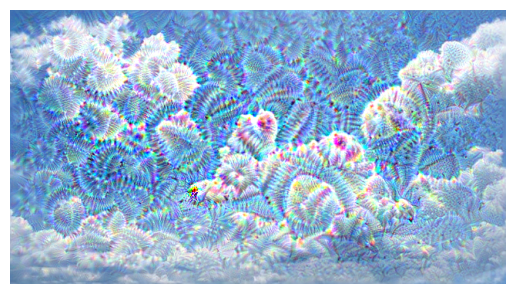

In [34]:
import matplotlib.pyplot as plt
plt.imshow(deprocess_image(img.numpy())) # 이미지 복원 함수 사용
plt.axis('off')
plt.show()